In [1]:
import pandas as pd
import numpy as np
import random
from igraph import *
from itertools import combinations
from tqdm.notebook import tqdm
import copy
from make_cluster_names import make_cluster_aliases

pd.set_option('max_colwidth', 1000)

## plotting
from plotnine import *
from mizani.formatters import percent_format

theme_publication = theme_bw() + theme(text=element_text(family="cmr10", size=12, color="black"),
                                       axis_title=element_text(size=14))

In [2]:
lnsnapshotFile = "../data/joined/level_2/lnsnapshot2020-02-24.csv"
lightningNodeClustersFile = "../data/joined/results/alias_address_clusters.csv"
channelCreatorsFile = "../data/joined/results/funding_node_channel.csv"
#outputFile = "clusterStats2020-02-24-new.csv"

In [3]:
aliasip_clusters = pd.read_csv(lightningNodeClustersFile)

In [4]:
edgelist = pd.read_csv(lnsnapshotFile)
edgelist = edgelist.rename(columns={"node1_pub":"node1", "node2_pub":"node2"})
edgelist = edgelist[["node1", "node2", "capacity", "chan_point"]]
edgelist

,node1,node2,capacity,chan_point
0,03bd3466efd4a7306b539e2314e69efc6b1eaee29734fcedd78cf81b1dde9fedf8,03c3d14714b78f03fd6ea4997c2b540a4139258249ea1d625c03b68bb82f85d0ea,37200,ede04f9cfc1bb5373fd07d8af9c9b8b5a85cfe5e323b7796eb0a4d0dce5d5058:1
1,02eccebd9ed98f6d267080a58194dbe554a2b33d976eb95bb7c116d00fd64c4a13,02ee4469f2b686d5d02422917ac199602ce4c366a7bfaac1099e3ade377677064d,1000000,cfd0ae79fc150c2c3c4068ceca74bc26652bb2691624379aba9e28b197a78d6a:0
2,02eccebd9ed98f6d267080a58194dbe554a2b33d976eb95bb7c116d00fd64c4a13,02ee4469f2b686d5d02422917ac199602ce4c366a7bfaac1099e3ade377677064d,1000000,c0a8d3428f562c232d86be399eb4497934e7e0390fa79e6860bcb65e7b0dd4fe:1
3,03bd3466efd4a7306b539e2314e69efc6b1eaee29734fcedd78cf81b1dde9fedf8,03cbf298b068300be33f06c947b9d3f00a0f0e8089da3233f5db37e81d3a596fe1,200000,06bbac25ed610feb1d07316d1be8b8ba6850ee1dd96cc1d5439159bfe992be5a:1
4,022e74ed3ddd3f590fd6492e60b20dcad7303f17e1ffd882fb33bb3f6c88f64398,02ee4469f2b686d5d02422917ac199602ce4c366a7bfaac1099e3ade377677064d,2000000,2392c45431c064269e4eaeccb0476ac32e56485d84e104064636aea896d1e439:0
...,...,...,...,...
36162,0217890e3aad8d35bc054f43acc00084b25229ecff0ab68debd82883ad65ee8266,029cd00aca967ad1b635fa245198c1907bceebec80487b3ee41c52c693ce25261d,100000,8ed4aab991fa862f5f0e6a36a836b30f2bd1a774d6bfb85a88d63c1a67e44684:0
36163,0331f80652fb840239df8dc99205792bba2e559a05469915804c08420230e23c7c,03e691f81f08c56fa876cc4ef5c9e8b727bd682cf35605be25d48607a802526053,8000000,e8f79bfb53353f54029a86976c4633c3f65ef854cebcf0aaace70c09a1860936:1
36164,03bb88ccc444534da7b5b64b4f7b15e1eccb18e102db0e400d4b9cfe93763aa26d,03d480ac7ad220371f1b9c2560be7eb8da6335d6a0d8cb1bc27db1a3958fd8c73f,2000000,7eac4e8a138c6af4b0f332ec497dc33226ae6401af330ec9cc44a1de17192ca4:1
36165,02480c283dea91c64dd76777ade0517cf697a42ac7dd4892735b41d456f381a450,030365ca0e656453e44b7da30d2643f1f6183cfe2a3bdb59b69aa8bde1136ca758,1000000,322fb69958d9428af10a85e8aa5e4c7f36de3aa07981f51511709bd18c5b4c24:1


In [14]:
len(g.vs)

6481

In [6]:
# Create an igraph object based on the edge list
tuples = [tuple(x) for x in edgelist[["node1", "node2", "capacity"]].values]
g = Graph.TupleList(tuples, directed = False, edge_attrs = ['weight'])

id_to_name = dict(map(lambda x: (x.index, x['name']), list(g.vs)))
name_to_id = {v: k for k, v in id_to_name.items()}

In [7]:
existing_entities = aliasip_clusters[aliasip_clusters.pub_key.isin([id_to_name[v.index] for v in g.vs()])]
existing_entities = existing_entities.groupby("cluster").filter(lambda x: len(x) > 1)
cluster_aliases = make_cluster_aliases(existing_entities)
#aliases = existing_entities[existing_entities.cluster == 180].alias.tolist()
#[item for sublist in [alias.split(" | ") for alias in aliases] for item in sublist]

In [8]:
totalCapacity = edgelist.capacity.sum()
totalChannels = len(edgelist)

# Compute Diameter

In [17]:
g.diameter()

12

# Compute cluster capacity shares

In [9]:
n1c = existing_entities[["pub_key", "cluster"]].rename(columns={"pub_key":"node1", "cluster":"n1_c"})
n2c = existing_entities[["pub_key", "cluster"]].rename(columns={"pub_key":"node2", "cluster":"n2_c"})

capacity_from_linking = pd.read_csv(channelCreatorsFile)
capacity_from_linking.rename(columns = {"channel":"chan_point"}, inplace=True)

channel_funders = edgelist.merge(capacity_from_linking, on="chan_point", how="left")
channel_funders = channel_funders.merge(n1c, on="node1", how="left").merge(n2c, on="node2", how="left")

In [10]:
def attribute_channel_capacity_to_node(row):
    capacity = row["capacity"]
    correctExists = not pd.isnull(row["funding_node"])
    n1cExists = not pd.isnull(row["n1_c"])
    n2cExists = not pd.isnull(row["n2_c"])
    if(correctExists):
        return({row["funding_node"]:capacity})
    elif(n1cExists and not n2cExists):
        return({row["node1"]:capacity})
    elif(n2cExists and not n1cExists):
        return({row["node2"]:capacity})
    else: # either both nodes are in a cluster, or none are
        return({row["node1"]:capacity/2, row["node2"]:capacity/2})

In [11]:
clist = channel_funders.apply(attribute_channel_capacity_to_node, axis=1).tolist()
capacities = pd.DataFrame([(k,v) for x in clist for (k, v) in x.items()], columns = ["pub_key", "capacity"])
node_capacity_share = (capacities.groupby("pub_key")["capacity"].sum()/totalCapacity).reset_index()
cluster_capacity_share = node_capacity_share.merge(existing_entities, on="pub_key", how="inner")
cluster_capacity_share = cluster_capacity_share.groupby("cluster")["capacity"].sum().reset_index()
cluster_capacity_share = cluster_capacity_share.merge(cluster_aliases)

In [16]:
cluster_capacity_share = cluster_capacity_share.sort_values("capacity", ascending=False)#.cluster.tolist()
cluster_capacity_share.head()

,cluster,capacity,cluster_size,alias
36,74,0.363504,26,"LNBIG.com *, ..."
27,56,0.039063,2,"Thor, ..."
25,53,0.020601,2,CoinGate
42,82,0.009192,2,*rompert.com*
32,68,0.008427,2,Breez


/opt/anaconda/3.7/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 5 x 3.5 in image.
  from_inches(height, units), units), PlotnineWarning)
/opt/anaconda/3.7/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /tmp/capacity_share_contributed.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


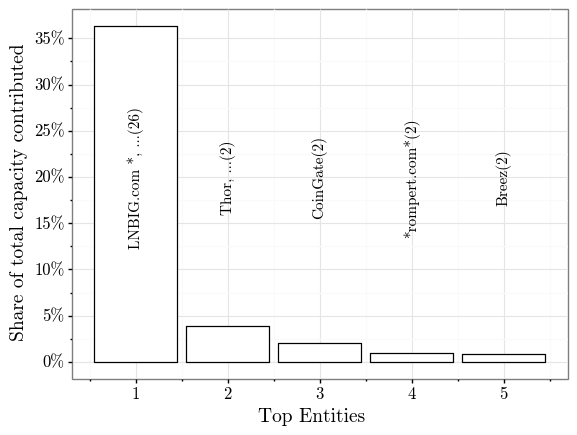

<ggplot: (8787138847990)>

In [13]:
capacity_share_for_plot = cluster_capacity_share.sort_values("capacity", ascending=False)
capacity_share_for_plot["entity_name"] = capacity_share_for_plot.apply(lambda x: str(x["alias"]) + "("+str(x["cluster_size"])+")", axis=1)
entity_name_list = capacity_share_for_plot['entity_name'].values.tolist()
entity_name_cat = pd.Categorical(capacity_share_for_plot['entity_name'], categories=entity_name_list)
capacity_share_for_plot = capacity_share_for_plot.assign(entity_name_cat = entity_name_cat)
capacity_share_for_plot = capacity_share_for_plot.reset_index(drop=True).reset_index()
capacity_share_for_plot["index"] = capacity_share_for_plot["index"]+1
capacity_share_for_plot["cumsum"] = capacity_share_for_plot.capacity.cumsum()

plot = ggplot(capacity_share_for_plot.head()) +\
geom_bar(aes(x="index", y="capacity"), stat="identity", color="black", fill="white") +\
geom_text(aes(x="index", y=0.2, label="entity_name_cat"),angle=90) +\
scale_y_continuous(labels=percent_format(), breaks=np.arange(0, 0.40, 0.05)) +\
theme_publication +\
labs(x="Top Entities", y="Share of total capacity contributed")

plot.save("/tmp/capacity_share_contributed.pdf", width=5, height=3.5)
plot

In [ ]:
plot = ggplot(capacity_share_for_plot) +\
geom_line(aes(x="index", y="cumsum")) +\
geom_point(data=capacity_share_for_plot, mapping=aes(x="index", y="cumsum")) +\
geom_text(data=capacity_share_for_plot.head(7),
          mapping=aes(x="index", y="cumsum", label="entity_name_cat"), ha='left', nudge_x=5) +\
scale_y_continuous(labels=percent_format()) +\
scale_x_continuous(breaks=[1,50,100,150,200]) +\
labs(x="Top Entities", y="Cumulative share of total capacity") +\
theme_publication

plot.save("/tmp/capacity_share_contributed_cumulative.pdf", width=5, height=4)
plot

In [ ]:
foo = node_capacity_share.sort_values("capacity", ascending=False)
foo["cumushare"] = foo["capacity"].cumsum()
foo = foo.reset_index(drop=True)
print(foo[foo["cumushare"] >= 0.8].iloc[0].name + 1, "of", g.vcount(), "nodes control 80% of capacity.")

# Component disintegration

In [25]:
comp = g.components(mode="WEAK")
len(g.components(mode="WEAK"))

39

In [26]:
def count_components(graph):
    return(len(graph.components(mode="WEAK")))

def size_largest_component(graph):
    return(len(graph.clusters().giant().vs()))

In [27]:
localG = copy.deepcopy(g)

original_component_count = count_components(localG)
original_component_size = size_largest_component(localG)

coResult = list()
coResult.append({"cluster":None, "size_largest_component": original_component_size})

for entity_id in tqdm(cluster_capacity_share.cluster.unique().tolist()):
    entity_pub_keys = existing_entities[existing_entities.cluster==entity_id].pub_key.values.tolist()
    ids_to_delete = [localG.vs.find(pub_key).index for pub_key in entity_pub_keys]
    localG.delete_vertices(ids_to_delete)
    coResult.append({"cluster": entity_id,
                    "size_largest_component": size_largest_component(localG)})

removalStats = pd.DataFrame(coResult)
removalStats["largest component"] = 1 - (removalStats["size_largest_component"] / original_component_size)
removalStats = removalStats.reset_index()


,cluster,size_largest_component,largest component
0,74,6065,0.051751
1,74,6045,0.054878
2,74,6028,0.057536
3,74,5969,0.066760
4,74,5960,0.068168
...,...,...,...
117,74,5539,0.133990
118,74,5537,0.134303
119,74,5535,0.134615
120,74,5535,0.134615


# Define grieving functions

In [ ]:
def performMaxFlowAndUpdateWeights(g, source, target):
    mf = g.maxflow(source=name_to_id[source],
                   target=name_to_id[target], capacity='weight')
    for (index, flow) in enumerate(mf.flow):
        newCapacity = g.es[index]['weight'] - abs(flow)
        g.es[index].update_attributes({'weight': newCapacity})
        g.es[index].update_attributes({'label': newCapacity})
    
    return(mf.value)

def performGrieving(g, entity_nodes):
    cumulativeFlow = 0
    for (source, target) in tqdm(list(combinations(entity_nodes, 2)), leave=False):
        cumulativeFlow += performMaxFlowAndUpdateWeights(g, source, target)
    return(cumulativeFlow)
    # idea, if you want to send funds to yourself:
    # start max-flow from every neighbor to yourself,
    # setting an upper capacity limit for the neighbor channels
    # to the capacity you have to the neighbor
    
def performGrievingByEntityId(g, eid):
    coins = performGrieving(g, existing_entities[existing_entities.cluster==eid].pub_key.values.tolist())
    cCount = len([edge for edge in g.es if edge["weight"] == 0])
    return({"cluster":eid, "coins":coins, "cCount":cCount})

In [ ]:
individualGrievingResList = list()
for entity_id in tqdm(existing_entities.cluster.unique().tolist()):
    gcopy = copy.deepcopy(g)
    individualGrievingResList.append(performGrievingByEntityId(gcopy, entity_id))

In [ ]:
individualGrievingRes = pd.DataFrame(individualGrievingResList)
individualGrievingRes = individualGrievingRes.merge(cluster_aliases, on="cluster")
individualGrievingRes["capacityShare"] = individualGrievingRes["coins"] / totalCapacity
individualGrievingRes["channelShare"] = individualGrievingRes["cCount"] / totalChannels
individualGrievingRes = individualGrievingRes.sort_values("capacityShare", ascending = False)
individualGrievingRes

In [ ]:
grieving_share_for_plot = individualGrievingRes.sort_values("capacityShare", ascending=False)
grieving_share_for_plot["entity_name"] = grieving_share_for_plot.apply(lambda x: str(x["alias"]) + "("+str(x["cluster_size"])+")", axis=1)
entity_name_list = grieving_share_for_plot['entity_name'].values.tolist()
entity_name_cat = pd.Categorical(grieving_share_for_plot['entity_name'], categories=entity_name_list)
grieving_share_for_plot = grieving_share_for_plot.assign(entity_name_cat = entity_name_cat)
grieving_share_for_plot = grieving_share_for_plot.reset_index(drop=True).reset_index()
grieving_share_for_plot["index"] = grieving_share_for_plot["index"]+1

plot = ggplot(grieving_share_for_plot.head()) +\
geom_bar(aes(x="index", y="capacityShare"), stat="identity", color="black", fill="white") +\
geom_text(aes(x="index", y=0.08, label="entity_name_cat"),angle=90) +\
scale_y_continuous(labels=percent_format()) +\
theme_publication +\
labs(x="Top Entities", y="Griefed network capacity")

plot.save("/tmp/capacity_share_griefed.pdf", width=5, height=3.5)
plot

In [ ]:
grieving_share_for_plot = individualGrievingRes.sort_values("channelShare", ascending=False)
grieving_share_for_plot["entity_name"] = grieving_share_for_plot.apply(lambda x: str(x["alias"]) + "("+str(x["cluster_size"])+")", axis=1)
entity_name_list = grieving_share_for_plot['entity_name'].values.tolist()
entity_name_cat = pd.Categorical(grieving_share_for_plot['entity_name'], categories=entity_name_list)
grieving_share_for_plot = grieving_share_for_plot.assign(entity_name_cat = entity_name_cat)
grieving_share_for_plot = grieving_share_for_plot.reset_index(drop=True).reset_index()
grieving_share_for_plot["index"] = grieving_share_for_plot["index"]+1

plot = ggplot(grieving_share_for_plot.head()) +\
geom_bar(aes(x="index", y="channelShare"), stat="identity", color="black", fill="white") +\
geom_text(aes(x="index", y=0.2, label="entity_name_cat"),angle=90) +\
scale_y_continuous(labels=percent_format(), breaks=np.arange(0, 0.50, 0.1)) +\
theme_publication +\
labs(x="Top Entities", y="Share of all channels blocked")

plot.save("/tmp/channel_share_griefed.pdf", width=5, height=3.5)
plot

In [ ]:
combined_data = individualGrievingRes.sort_values("capacityShare", ascending=False).head(5)
combined_data = combined_data.reset_index(drop=True).reset_index().rename(columns={"index":"position"})
combined_data["position"] += 1
combined_data = pd.melt(combined_data.rename(columns={"capacityShare":"of total capacity", "channelShare":"of all channels"}),
                        id_vars=["position", "cluster_size", "alias"],
                        value_vars=["of total capacity", "of all channels"])
plot = ggplot(combined_data) +\
geom_bar(aes(x="position", y="value", fill="variable"), position="dodge", stat="identity", color="black") +\
geom_text(data=combined_data[combined_data.variable == "of total capacity"],
          mapping=aes(x="position", y="value", label="alias"), angle=90, va="baseline", nudge_y=0.065, nudge_x=0.25) +\
labs(x="Top entities", y="Share locked with\n griefing attack", fill="") +\
scale_y_continuous(labels=percent_format()) +\
theme_publication +\
theme(legend_position="bottom")

plot.save("/tmp/griefed_share_combined.pdf", width=5, height=3.5)
plot

In [ ]:
cumulativeGrievingResList = list()
gcopy = copy.deepcopy(g)
for entity_id in tqdm(cluster_capacity_share.cluster.unique().tolist()):
    existing_entities[existing_entities.cluster==eid].pub_key.values.tolist()
    cumulativeGrievingResList.append(performGrievingByEntityId(gcopy, entity_id))

In [ ]:
cumulativeGrievingRes = pd.DataFrame(cumulativeGrievingResList)
cumulativeGrievingRes = cumulativeGrievingRes.merge(cluster_aliases, on="cluster")
cumulativeGrievingRes["cumucoins"] = cumulativeGrievingRes["coins"].cumsum()
cumulativeGrievingRes["capacityShare"] = cumulativeGrievingRes["cumucoins"] / totalCapacity
cumulativeGrievingRes["channelShare"] = cumulativeGrievingRes["cCount"] / totalChannels
cumulativeGrievingRes

In [ ]:
ggplot(cumulativeGrievingRes.reset_index()) +\
geom_line(aes(x="index", y="capacityShare")) +\
labs(x="Entity index", y="Cumulative capacity griefed") +\
theme_publication

# Average maximum flow with uniform random sampling

In [18]:
pairs = 1000

# node pairs except nodes from our clusters
nodePairs = list(combinations([v["name"] for v in g.vs if v["name"] not in existing_entities.pub_key.tolist()], 2))
# draw 
random.seed(0)
randomPairs = random.choices(nodePairs, k=pairs)

def estimateAvgMaxFlow(g):
    #randomPairs = random.choices(list(combinations([v.index for v in g.vs], 2)), k=k)
    avgMaxFlow = np.array(
        [g.maxflow_value(g.vs.find(s).index, g.vs.find(t).index, capacity="weight") for (s, t) in tqdm(randomPairs, leave=False)]).mean()
    return(avgMaxFlow)

localG = copy.deepcopy(g)
mfResults = list()
initialAvgMaxFlow = estimateAvgMaxFlow(localG)
mfResults.append({"cluster":None, "avgMaxFlow": initialAvgMaxFlow})

for entity_id in tqdm(cluster_capacity_share.cluster.unique().tolist()):
    entity_pub_keys = existing_entities[existing_entities.cluster==entity_id].pub_key.values.tolist()
    vids = [v.index for v in localG.vs if v["name"] in entity_pub_keys]
    #vids = [name_to_id[pub_key] for pub_key in entity_pub_keys]
    #print(vids)
    localG.delete_vertices(vids)
    stat = {"cluster":entity_id, "avgMaxFlow":estimateAvgMaxFlow(localG)}
    print(stat)
    mfResults.append(stat)
    

{'cluster': 74, 'avgMaxFlow': 1041668.466}


{'cluster': 56, 'avgMaxFlow': 985075.882}


{'cluster': 53, 'avgMaxFlow': 964551.487}


{'cluster': 82, 'avgMaxFlow': 940028.291}


{'cluster': 68, 'avgMaxFlow': 933156.698}


{'cluster': 54, 'avgMaxFlow': 913639.076}


{'cluster': 38, 'avgMaxFlow': 901442.014}


{'cluster': 174, 'avgMaxFlow': 892878.896}


{'cluster': 191, 'avgMaxFlow': 887406.988}


{'cluster': 225, 'avgMaxFlow': 887083.261}


{'cluster': 218, 'avgMaxFlow': 883500.852}


{'cluster': 77, 'avgMaxFlow': 882200.852}


{'cluster': 7, 'avgMaxFlow': 882200.852}


KeyboardInterrupt: 

In [19]:
mfResultsDF = pd.DataFrame(mfResults).reset_index()
mfResultsDF["advantage"] = 1 - (mfResultsDF["avgMaxFlow"]/initialAvgMaxFlow)
mfResultsDF

,index,cluster,avgMaxFlow,advantage
0,0,NaN,1600323.281,0.000000
1,1,74.0,1041668.466,0.349089
2,2,56.0,985075.882,0.384452
3,3,53.0,964551.487,0.397277
4,4,82.0,940028.291,0.412601
5,5,68.0,933156.698,0.416895
6,6,54.0,913639.076,0.429091
7,7,38.0,901442.014,0.436713
8,8,174.0,892878.896,0.442063
9,9,191.0,887406.988,0.445483


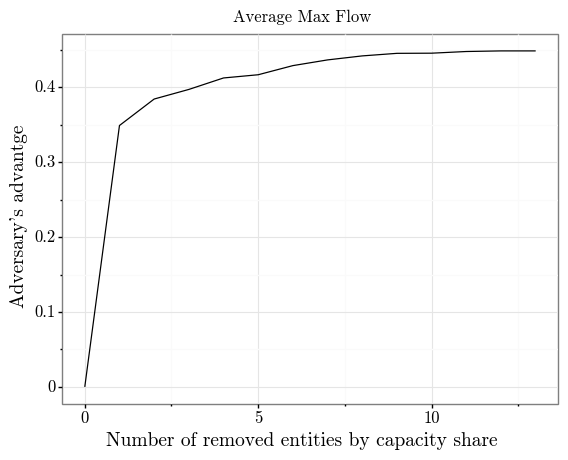

<ggplot: (-9223363245515411484)>

In [20]:
plot = ggplot(mfResultsDF) +\
geom_line(aes(x="index", y="advantage")) +\
labs(x="Number of removed entities by capacity share", y="Adversary's advantge") +\
theme_publication +ggtitle("Average Max Flow")

plot

In [93]:
existing_entities

,cluster,pub_key,cluster_origin,alias
4,2,021d9deaf090a021c6e464e3becc5296161e8aaf5de3c7a1d517838cd74525834f,alias/asn & address,Gordon.Now
5,2,03b73bda986a22fbc47a2fc1764b59e779fb0473d0428dd4bca4ffb2a183eff2da,alias/asn & address,Gordon.Now Wallet
12,6,02c3efe2874e29d5fc21df59402789c392b3a327b80e76fc103331dbe724d69316,alias/asn & address,mayflower
13,6,02f14f2b8606b94c96b6526d7758efa9c610d9c6a84325bffb1b4ff857defb13f9,alias/asn & address,mayflower
15,7,0250e86fdaaefd59ea7481c53ee6d7e1b01e2bfd582fdddab768cfa9e8bd923b17,alias/asn & address,phecda-325 [bitclouds.sh]
...,...,...,...,...
576,226,03fd43afc8beb0e1fc1cc8d8702cd237e8f27970de8acfb4569b13ea789631d40e,address,Guergen
577,227,024dcb28330bb766def5e85e064dab3dfb472419d855d05b1e32637c4e7339ada9,address,FreeBitcoin
578,227,03c45e83933fd5058e2381630df99a7e01660f4e97b3a3b2c305a23956158bdeda,address,LupusPluviaLND | Lupus-Pluvia-LND-Bank🐾🐺 | LupusPluviaLNDBank
579,228,0276e09a267592e7451a939c932cf685f0754de382a3ca85d2fb3a864d4c365ad5,address,"""Cheese"""


# Expected payment success ratio

In [21]:
#np.random.seed(0)
#random.seed(0)

fraction = 0.1
attempts = 1000
amountsUsed = list()

# node pairs except nodes from our clusters
nodePairs = list(combinations([v["name"] for v in g.vs if v["name"] not in existing_entities.pub_key.tolist()], 2))
# draw 
random.seed(0)
randomPairs = random.choices(nodePairs, k=attempts)

# draw random capacities and take a fraction
np.random.seed(0)
randomAmounts = np.random.choice(edgelist.capacity, attempts) * fraction

def computeSuccessRatio(g):
    successfulPayments = 0
    failedPayments = 0
    for ((s, t), amount) in tqdm(list(zip(randomPairs, randomAmounts))):
        amountsUsed.append(amount)
        
        psg = copy.deepcopy(g)
        psg.delete_edges([e.index for e in psg.es if e["weight"] <= amount])

        # check if there exists a path from source to target
        src = g.vs.find(s)
        dst = g.vs.find(t)
        pathlength = psg.shortest_paths_dijkstra(source = src, target = dst)[0][0]
        if(pathlength == np.inf):
            failedPayments += 1
        else:
            successfulPayments += 1

    successRatio = successfulPayments / (successfulPayments + failedPayments)
    return(successRatio)
    
localG = copy.deepcopy(g)
psResults = list()
initialPaymentSuccess = computeSuccessRatio(localG)
psResults.append({"cluster":None, "paymentSuccess": initialPaymentSuccess})
print(psResults)


for entity_id in tqdm(cluster_capacity_share.cluster.unique().tolist()):
    entity_pub_keys = existing_entities[existing_entities.cluster==entity_id].pub_key.values.tolist()
    vids = [v.index for v in localG.vs if v["name"] in entity_pub_keys]
    localG.delete_vertices(vids)
    
    stat = {"cluster":entity_id, "paymentSuccess":computeSuccessRatio(localG)}
    print(stat)
    psResults.append(stat)


[{'cluster': None, 'paymentSuccess': 0.597}]



{'cluster': 74, 'paymentSuccess': 0.529}



{'cluster': 56, 'paymentSuccess': 0.525}



{'cluster': 53, 'paymentSuccess': 0.522}



{'cluster': 82, 'paymentSuccess': 0.517}



{'cluster': 68, 'paymentSuccess': 0.517}



{'cluster': 54, 'paymentSuccess': 0.512}



{'cluster': 38, 'paymentSuccess': 0.504}



{'cluster': 174, 'paymentSuccess': 0.502}



{'cluster': 191, 'paymentSuccess': 0.502}



{'cluster': 225, 'paymentSuccess': 0.502}



{'cluster': 218, 'paymentSuccess': 0.502}



{'cluster': 77, 'paymentSuccess': 0.502}



{'cluster': 7, 'paymentSuccess': 0.502}



{'cluster': 103, 'paymentSuccess': 0.502}



{'cluster': 110, 'paymentSuccess': 0.502}



{'cluster': 70, 'paymentSuccess': 0.501}



{'cluster': 180, 'paymentSuccess': 0.499}



{'cluster': 108, 'paymentSuccess': 0.499}



{'cluster': 76, 'paymentSuccess': 0.499}



{'cluster': 120, 'paymentSuccess': 0.497}



{'cluster': 160, 'paymentSuccess': 0.497}



{'cluster': 113, 'paymentSuccess': 0.497}


KeyboardInterrupt: 

In [22]:
psResultsDF = pd.DataFrame(psResults).reset_index()
psResultsDF["advantage"] = 1 - (psResultsDF["paymentSuccess"]/initialPaymentSuccess)
psResultsDF

,index,cluster,paymentSuccess,advantage
0,0,NaN,0.597,0.000000
1,1,74.0,0.529,0.113903
2,2,56.0,0.525,0.120603
3,3,53.0,0.522,0.125628
4,4,82.0,0.517,0.134003
5,5,68.0,0.517,0.134003
6,6,54.0,0.512,0.142379
7,7,38.0,0.504,0.155779
8,8,174.0,0.502,0.159129
9,9,191.0,0.502,0.159129


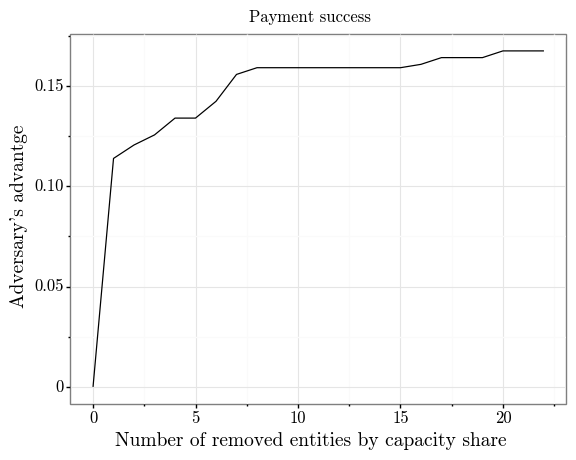

<ggplot: (-9223363245598695217)>

In [23]:
plot = ggplot(psResultsDF) +\
geom_line(aes(x="index", y="advantage")) +\
labs(x="Number of removed entities by capacity share", y="Adversary's advantge") +\
theme_publication +ggtitle("Payment success")

plot

In [31]:
combined = mfResultsDF.rename(columns={"advantage":"max-flow"}).merge(
    psResultsDF.rename(columns={"advantage":"payment success"}), on=["cluster", "index"]).merge(
    removalStats, on=["cluster", "index"])
combined.merge(cluster_aliases)

,index,cluster,avgMaxFlow,max-flow,paymentSuccess,payment success,size_largest_component,largest component,cluster_size,alias
0,1,74.0,1041668.466,0.349089,0.529,0.113903,6065,0.051751,26,"LNBIG.com *, ..."
1,2,56.0,985075.882,0.384452,0.525,0.120603,6045,0.054878,2,"Thor, ..."
2,3,53.0,964551.487,0.397277,0.522,0.125628,6028,0.057536,2,CoinGate
3,4,82.0,940028.291,0.412601,0.517,0.134003,5969,0.066760,2,*rompert.com*
4,5,68.0,933156.698,0.416895,0.517,0.134003,5960,0.068168,2,Breez
5,6,54.0,913639.076,0.429091,0.512,0.142379,5948,0.070044,2,"tippin.me, ..."
6,7,38.0,901442.014,0.436713,0.504,0.155779,5901,0.077392,2,BitMEXResearch
7,8,174.0,892878.896,0.442063,0.502,0.159129,5889,0.079268,2,"Sagittarius A, ..."
8,9,191.0,887406.988,0.445483,0.502,0.159129,5882,0.080363,2,LightningPeachH...
9,10,225.0,887083.261,0.445685,0.502,0.159129,5875,0.081457,2,"PeerName.com, ..."


/opt/anaconda/3.7/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 5 x 3.5 in image.
  from_inches(height, units), units), PlotnineWarning)
/opt/anaconda/3.7/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /tmp/combined-max-flow-payment-success-component.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


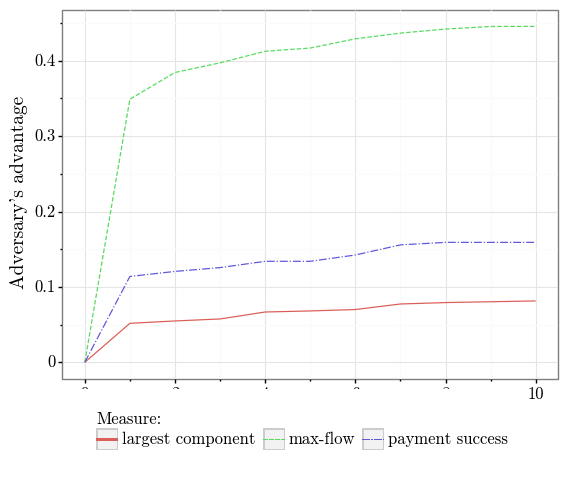

<ggplot: (-9223363245598707326)>

In [29]:
combined_for_plot = pd.melt(combined ,id_vars="index", value_vars=["max-flow", "payment success", "largest component"])
plot = ggplot(combined_for_plot[combined_for_plot["index"] <= 10]) +\
geom_line(aes(x="index", y="value", color="variable", linetype="variable")) +\
theme_publication +\
scale_x_continuous(breaks=[0,2,4,6,8,10]) +\
labs(x="Number of removed entities by capacity share", y="Adversary's advantage", color="Measure:", linetype="Measure:") +\
theme(legend_position="bottom")

plot.save("/tmp/combined-max-flow-payment-success-component.pdf", width=5, height=3.5)
plot

In [ ]:
g.es["label"] = mf.flow
mf.es["color"] = "red"
plot(mf.graph, edge_label = mf.flow)

In [ ]:
#for (e,flow) in list(zip(g.es, mf.flow)):
for index, flow in enumerate(mf.flow):
    newCapacity = g.es[index]["weight"] - abs(flow)
    print(index, "capacity:", g.es[index]["weight"], "flow:", flow, newCapacity)
    g.es[index].update_attributes({"weight":newCapacity})
    g.es[index].update_attributes({"label":newCapacity})
    #g.es[e.index]["weight"] = g.es[e.index]["weight"] - abs(flow)
    #print(e.index, e["weight"], abs(flow))

In [ ]:
print(performMaxFlowAndUpdateWeights(g, 4, 6))
plot(g)

In [ ]:
from itertools import combinations
for (source, target) in list(combinations([1,2,3,4], 2)):

In [ ]:
#[edge for edge in g.es if edge["weight"] == 0]

In [ ]:
len(list(combinations([edge.index for edge in g.es], 2)))